# BLI single-tip method data analysis example - *work in progress*
# intro


This jupyter notebook walks you through how to analyze BLI data generate using the "single tip method", where a single tip is used repeatedly to measure binding across a range of titrant (species not on the tip) concentrations.

I would suggest running this example analysis and then using the functions here to analyse your own data. **This is an example analysis of some data that I collected and is meant to teach you how to use the tools, but it is not a ready made script where you can just press go and get binding curves**
To export a plot made using pyplot, add the `plt.savefig('filename.jpg',dpi=200)` to the cell in which it was generated.

**Requirements**: This notebook requires Python3, and the following modules:

* `plotly`
* `pandas`
* `matplotlib`
* `numpy`
* `lmfit`
* The script `BLI_tools.py` must be in the same directory as this notebook.

If you have anaconda, you probably already have these modules except for `lmfit`. Install using `conda install -c conda-forge lmfit`



## Required experiment-specific files

On the BLI instrument, export **raw data** file. It will be saved as something like `RawData0.xls`. If there are multiple raw data files, you can easily merge them as long as all of the data have different "tip well IDs". These are the wells in which the tips are stored prior to the experiment (see sensorplate image)
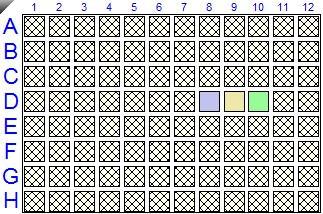
<br>
You will then need to make a `sample_key.csv` file. I make the file in excel and the save it as a `csv`. The `sample_key.csv` file just defines the name of the species on the tip (`tip`) and name of the species being titrated (`titrant`) for each "tip well ID". TODO: explain this better

example of what `sample_key.csv` should look like:

tip well | tip  |  titrant
-------- | ---  |  -------
A6   | pCare | INV
B6    |    pCare | INV
C6    |    pCare | INV
A7    |    empty | INV
B7    |    empty | INV
C7    |    empty | INV
D8    |    Lpd3 |  EVH1 only
D9    |    empty | EVH1 only
D10   |    SHIP2 | EVH1 only

## script idea/pipeline overview
*I wrote this script with the intention of it being modular - meaning you can look at and plot your data in different ways and deal with complicated plate setups dynamically. So you can plot subsets of the data in stages, decide which samples to calculate binding curves for, process samples with different loading times and different methods, etc.
<br>Therefore, for now, it requires you to examine the data and make decisions instead of just pressing go. If you have very reliable/normal looking data that always looks the same, it would be fairly easy to turn this into an easy to run script.*

**Basic pipeline**: *most of the functions for processing the data are in the file `BLI_tools.py`. I use pandas heavily so I use a dataframe for everything more or less*
1. import the `sample_key` as a dataframe 
2. import the data as a dataframe with `BLI_tools.import_raw_data()`
3. create a `BLI_data = BLI_tools.BLI_data_df()` object using the sample key and raw data as inputs
4. you can plot the raw data with `BLI_data.pyplot_plot_samples()` or `BLI_data.plotly_plot_samples()` at any point. I like to use `BLI_data.plotly_plot_samples()` and save and `.html` file of all the raw data at first so that I can look at it interactively later.
5. You can then use any of the `BLI_data.set...()` methods to select a subset of the data in different ways. There is a method for setting wells based on tip/titrant names, enumerating through well IDs, or setting the wells directly. (see below for more details)
6. If you want you can also baseline normalize the data using `BLI_data.zero_cols()`. It won't be relevant for the binding signal calculation however
7. To calculate binding curves, you first have to use `BLI_data.set_assay_times()` to set experimental parameters used for calculating the binding signal.
8. then you can preview how the binding signal will be calculated with `BLI_data.binding_signal_preview()`
9. Finally, you can calculate a binding curves with `BLI_data.generate_binding_curves2()` function and further process that however you would like.
<br> TODO: add method to do curve fitting and empty subtraction. output binding curve that is merged with sample_key to provide more info about samples
<br><br>
*Written by*: Jackson Halpin, July 2021 

## example overview
For the data here, I will be working with multiple datasets collected with the same plate, on the same date. 
- **part 0**: preparation and initial plotting
- **part 1**: Some of the data looks bad and we would not be able to fit it and so I am just going to make some plots of the raw data. 
- **part 2**: for the data that is good enough to fit, we will calculate binding curves. The 3 samples will have different loading times and so we'll have to deal with that

# Part 0 - preparation and initial plotting

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
import plotly.express as px
# plt.style.use('custom_standard')
# plt.style.use('custom_small')
from lmfit import Model

import BLI_tools as b
%load_ext autoreload
%autoreload 2

## import and merge datafiles

We have multiple datafiles, so I am just going to make a datafiles list and import/merge all of the datafiles into 1 dataframe.

In [2]:
datafiles = ['./Mena_INV_Pcare_Empty/RawData0.xls',
'./EVH1_only_LPD3_SHIP2/Experiment_1/RawData1.xls',
'./EVH1_only_LPD3_SHIP2/Experiment_1/RawData0.xls']
sample_key = pd.read_csv('./sample_key.csv')

In [3]:
dfs = []
for file in datafiles:
    dfs.append(b.import_raw_data(file))
df = pd.concat(dfs, axis=1)

## plot all the data and save as html
plot all the data and export as an html using plotly. you can open this file in a web browser later and look at the data interactively

In [4]:
data = b.BLI_data_df(df,sample_key)
fig = data.plotly_plot_samples()
fig.show()
fig.write_html('all_data.html')

---

# Tutorial: setting sample wells

you can set the sample wells to use using different methods:
- `data.set_wells_from_samplekey(tip='all', titrant='all')`
    - use tip/titrant names to set the samples. You can use lists of strings or single strings to set samples
- `data.set_wells_directly(cols)`
    - set the wells using a list of well IDs directly (e.g. `['A1', 'B2', 'C10']`)
- `data.set_wells_by_enumerating(letters, numbers)`
    - Examples:
``` 
>>> set_wells_by_enumerating('A', list(range(1, 7)))
['A1','A2','A3','A4','A5','A6']
>>> set_wells_by_enumerating('ABCD', [1,2,3])
['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3']
```

**Once you set sample wells, any subsequent methods run with the `data` object will only use the wells that you set** (see example below)
<br>use `data.sample_wells` to see the currently set samples

### Example

['D8', 'D10']


<AxesSubplot:xlabel='time (s)', ylabel='response (nm)'>

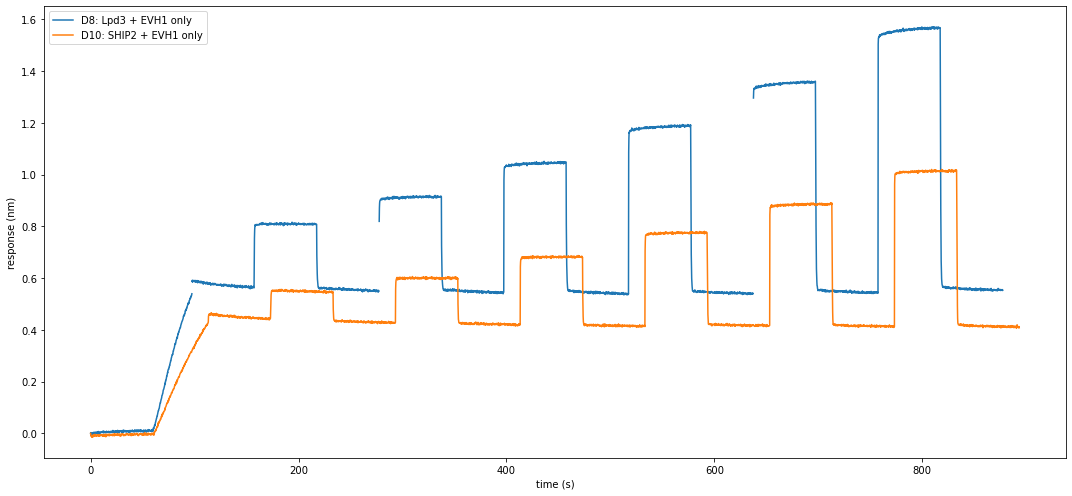

In [5]:
data.set_wells_from_samplekey(tip=['Lpd3','SHIP2'])
print(data.sample_wells)
data.pyplot_plot_samples()

Setting the sample_wells does not remove any data from the object, it just designates which wells to use in subsequent methods. 
<br>Example - we can still set different wells after we've already ran the cell above:

['A6', 'B6', 'C6']


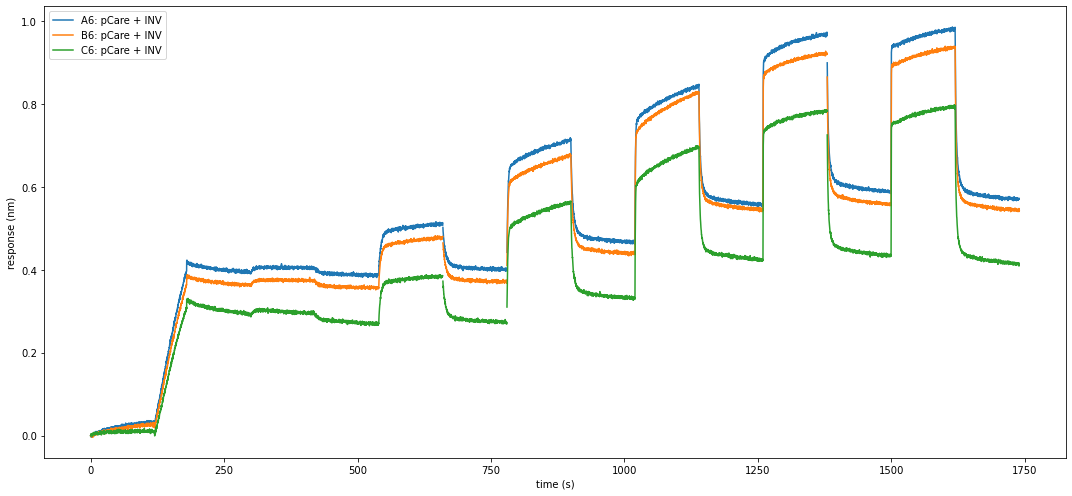

In [6]:
data.set_wells_by_enumerating('ABC',6)
data.pyplot_plot_samples()
print(data.sample_wells)

---

# Part 1 - "unfittable" data


### Let's make plots of just the INV data and save them as images

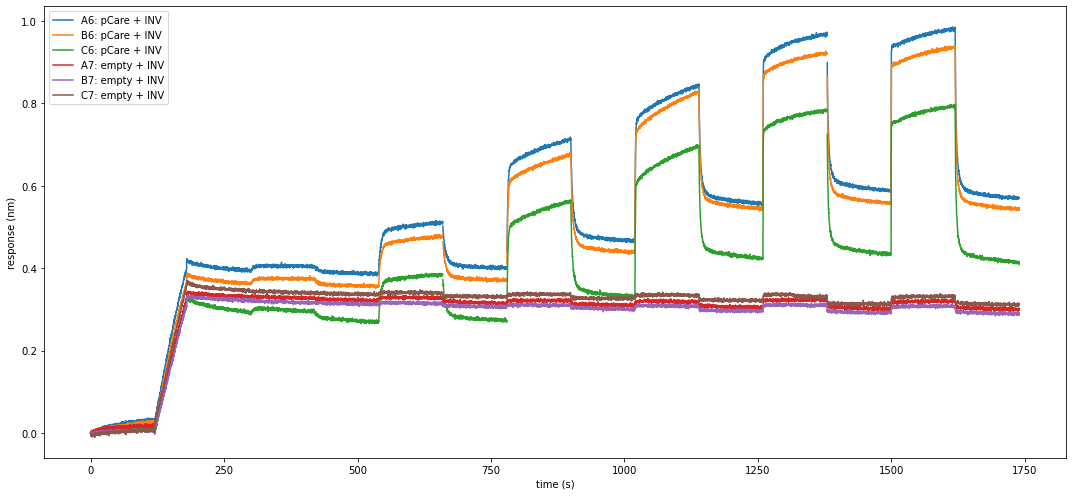

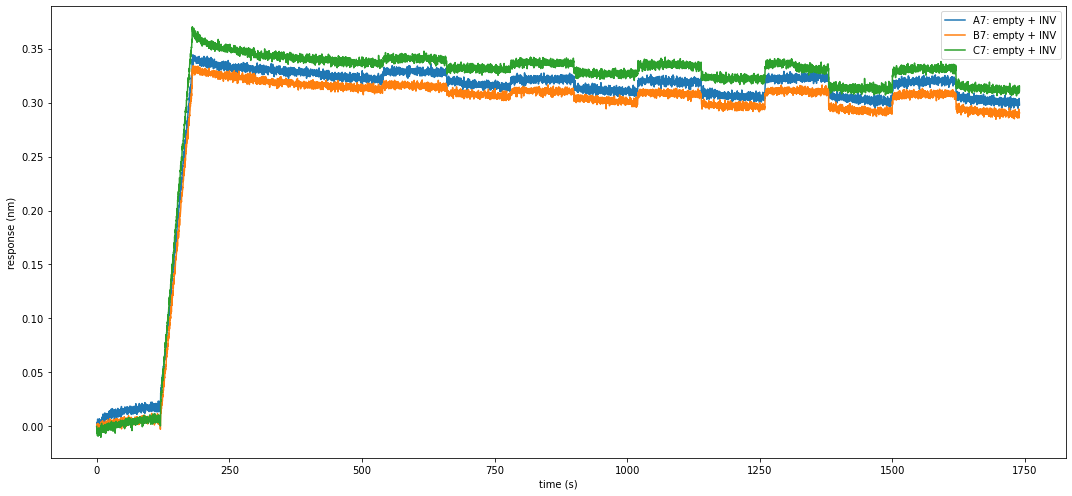

In [7]:
data.set_wells_from_samplekey(tip='all', titrant = 'INV')
data.pyplot_plot_samples()
plt.savefig('sig_INV.jpg',dpi=200)
data.set_wells_from_samplekey(tip='empty', titrant = 'INV')
data.pyplot_plot_samples()
plt.savefig('sig_INV_empty.jpg',dpi=200)

## baseline normalization

use the `data.zero_cols()` function to baseline normalize the data. Again, this doesn't destroy the original data (`data.df`), it creates a new normalized dataset (`data.baseline_subtracted_data`). Baseline normalizing the data is irrelevant for calculating binding curves with the way that we are calculating them, however you sometimes want to normalize for plotting.

In [8]:
data.set_wells_from_samplekey(titrant='INV')
data.zero_cols(280,290)
data.plotly_plot_samples(subtracted_data=True)

# Part 2: binding curves

Let's look at the good data that we will want to fit binding curves to

In [9]:
data.set_wells_from_samplekey(titrant='EVH1 only')
data.plotly_plot_samples()

In order to calculate binding signals, we have to define where the binding signal is for each concentration. We also have to set the concentrations used. This is all done by the `data.set_assay_times()` method, where you input the concentrations, loading time, and association/dissociation times.


If all of the data has the same loading times and association/dissociation times, you can process it all at once, otherwise, you will have to break it into chunks and process them individually using different inputs to `data.set_assay_times()`. This is where "setting sample wells" comes into play.

Looking at the plot above, you can tell that the 3 samples have different loading times, so we will have to process them each individually.

## set concentrations and method time steps

In [10]:
EVH1_concentrations = [3.125, 6.25, 12.5, 25, 50, 100]
association_t = 60 #seconds. Length of association step
dissociation_t = association_t # Length of dissociation step
dt=10 # amount of time that you want to average over to get signal


Let's look at this data first. We need to find the time point which we want to define as our first binding signal (at the end of the first association phase). Since the 3 different peptides have different loading times, we will have to process each titration individually, using a different initial offset time for each

## one at a time - D8

Set the `first_association_time` for the first sample and use the `data.binding_signal_preview()` function to get a look at how the signals are being calculated

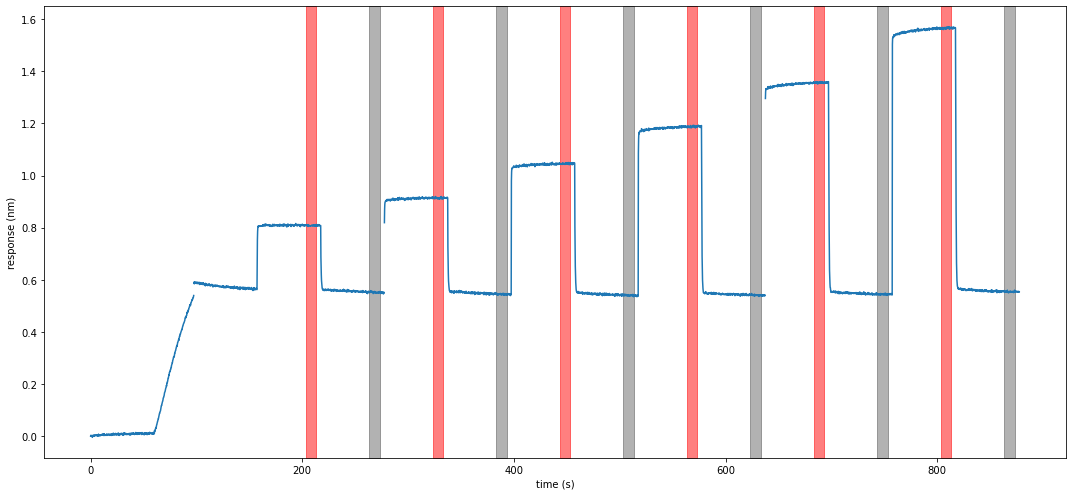

In [11]:
data.set_wells_directly('D8')

first_association_time = 203 # seconds - time that you want to use for the first binding signal
data.set_assay_times(first_association_time, association_t, dissociation_t, dt, EVH1_concentrations)
data.binding_signal_preview()
plt.savefig('signal_areas.jpg',dpi=200)

The binding signal is calculated as:<br>
(average value within the red shaded region) - (ave value within subsequent grey region)<br>
**See `data.set_assay_times()` documentation for more details**

In [12]:
binding_curves = data.generate_binding_curves2()

In [13]:
binding_curves

D8
3.125  0.256532
6.25    0.36928
12.5   0.505054
25     0.646539
50     0.812717
100    1.011977

## one at a time - D9

<AxesSubplot:xlabel='time (s)', ylabel='response (nm)'>

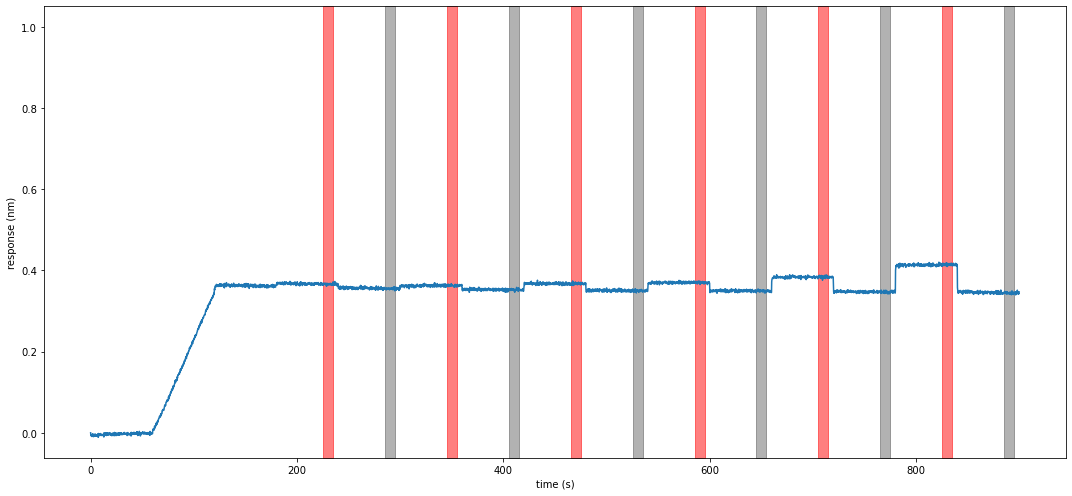

In [14]:
well = 'D9'
data.set_wells_directly(well)
first_association_time = 225 # seconds - time that you want to use for the first binding signal
data.set_assay_times(first_association_time, association_t, dissociation_t, dt, EVH1_concentrations)
data.binding_signal_preview()

In [15]:
binding_curves[well] = data.generate_binding_curves2()
binding_curves

D8        D9
3.125  0.256532  0.011216
6.25    0.36928  0.010138
12.5   0.505054  0.017833
25     0.646539  0.020731
50     0.812717  0.037102
100    1.011977  0.070084

## one at a time - D10

<AxesSubplot:xlabel='time (s)', ylabel='response (nm)'>

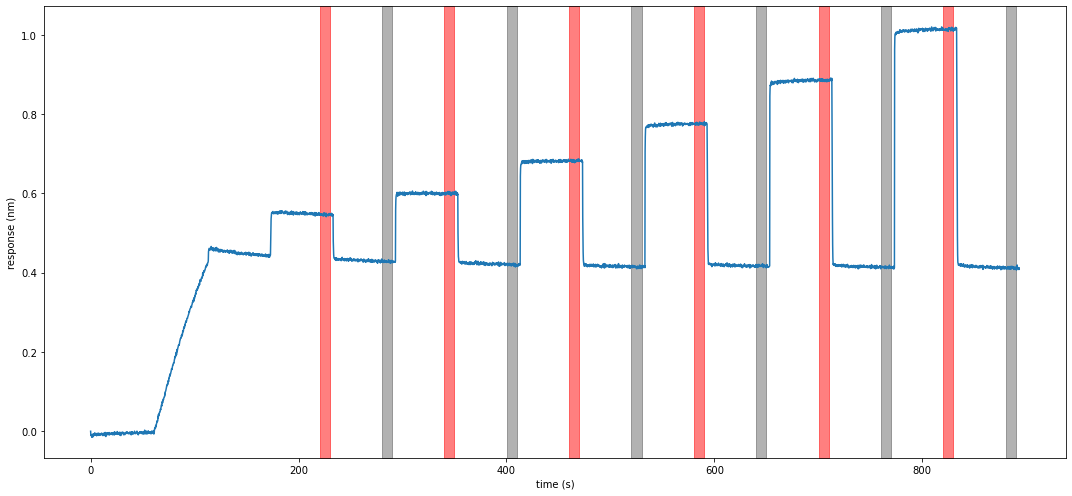

In [16]:
well = 'D10'
data.set_wells_directly(well)
first_association_time = 220 # seconds - time that you want to use for the first binding signal
data.set_assay_times(first_association_time, association_t, dissociation_t, dt, EVH1_concentrations)
data.binding_signal_preview()

In [17]:
binding_curves[well] = data.generate_binding_curves2()
binding_curves

D8        D9       D10
3.125  0.256532  0.011216   0.11778
6.25    0.36928  0.010138  0.179966
12.5   0.505054  0.017833  0.267412
25     0.646539  0.020731  0.358878
50     0.812717  0.037102  0.471634
100    1.011977  0.070084  0.601491

---

# you have binding curve data in `binding_curves`, the rest of the analysis (fitting/plotting binding curves) is up to you
### A typical workflow for the next steps might be:
- subtract empty binding curve(s) from other curves (will depend on how you set up experiment)
- fit binding curves, plot fits, etc.


### You can run `binding_curves.to_csv('filename.csv')` to export data and process it in an external program. 
### Below I processed the rest of my data using some quick code I wrote. I can't guarantee that my code will work for your data/analysis but feel free to take inspiration from it

In [18]:
# binding_curves.to_csv('filename.csv')

## Subtract the Empty signal from the other signals

In [19]:
empty_well = 'D9'
pep_wells=b.get_sample_wells(sample_key, tip='all', titrant='EVH1 only')
pep_wells.remove(empty_well)
empty_sig = binding_curves[empty_well]
fits = binding_curves[pep_wells].copy()
for i in pep_wells:
    fits[i]=fits[i]-empty_sig

In [20]:
fits = fits.T

In [21]:
fits

3.125      6.25      12.5        25        50       100
D8   0.245316  0.359142   0.48722  0.625808  0.775615  0.941894
D10  0.106563  0.169828  0.249579  0.338147  0.434532  0.531407

## fit and plot binding curves

In [22]:
# these functions are kind of complicated and involve applying a custom function to a dataframe. I took it from my pipeline for processing high throughput binding curves so there are certainly more simple ways to do this.


def fit_Kd(y, x, sample_key, plot=True):
    def basic_fit(x, init, sat, Kd):
        return init + (sat - init) * x / (x + Kd)

    # get rid of NaN values
    x2 = []
    y2 = []
    for yi,xi in zip(list(y),x):
        if ~np.isnan(yi):
            y2.append(yi)
            x2.append(xi)
    # fit curve
    gmod = Model(basic_fit)
    gmod.set_param_hint('Kd', value=0.1, min=0, max=40000)
    res = gmod.fit(y2, x=x2, init=0.1, sat=1)
    # build plot
    s = sample_key[sample_key['tip well']==y.name][['tip','titrant']].values[0]
    title = '{} - {} and {}'.format(y.name, s[0], s[1])
    if plot:
        plt.figure()
        res.plot_fit(numpoints=10000)
        plt.title("{} (Kd = {:.3g})".format(title, res.params['Kd'].value))
        plt.ylabel('binding signal - response (nm)')
        plt.xlabel('EVH1 concentration (uM)')
        plt.tight_layout()
        plt.savefig(title+'.jpg',dpi=200)
    return {'Kd':res.params['Kd'].value, 'fit SE':res.params['Kd'].stderr}


def apply_fit(df, concentrations, cols):
    # df = df.dropna()
    temp = df[cols].apply(
        fit_Kd,
        axis=1,
        result_type='expand',
        **{'x':concentrations,
          'sample_key':sample_key}
    )
    df = pd.concat([df, temp], axis = 'columns')
    return df

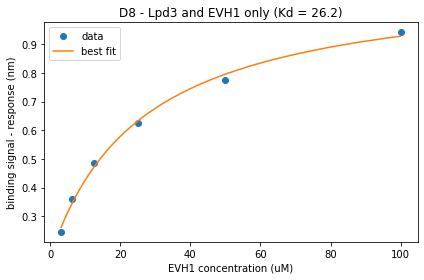

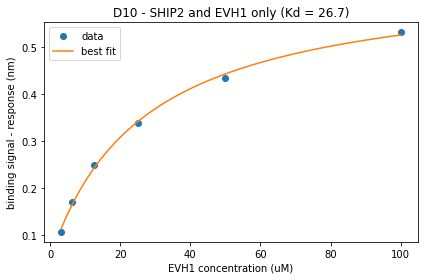

In [23]:
cols = [str(i) for i in EVH1_concentrations]
df = apply_fit(fits, EVH1_concentrations, cols)
df = df.reset_index().rename(columns={'index':'tip well'})
df2 = pd.merge(sample_key, df, on='tip well')

In [24]:
df2

tip well    tip    titrant     3.125      6.25      12.5        25  \
0       D8   Lpd3  EVH1 only  0.245316  0.359142   0.48722  0.625808   
1      D10  SHIP2  EVH1 only  0.106563  0.169828  0.249579  0.338147   

         50       100         Kd    fit SE  
0  0.775615  0.941894  26.228384  5.119548  
1  0.434532  0.531407  26.725968  3.600559

In [25]:
df2.to_csv('empty_subtracted_binding_curves.csv',index=False)

In [26]:
bc2 = binding_curves.T
bc2 = bc2.reset_index().rename(columns={'index':'tip well'})
bc3 = pd.merge(sample_key, bc2, on='tip well')
bc3.to_csv('unsub_binding_curves.csv',index=False)

In [27]:
!jupyter nbconvert --to html BLI_single_tip_analysis.ipynb

[NbConvertApp] Converting notebook BLI_single_tip_analysis.ipynb to html
/Users/jackson/opt/anaconda3/envs/traf/lib/python3.9/site-packages/nbconvert/filters/datatypefilter.py:39: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json']) is not able to be represented.
  warn("Your element with mimetype(s) {mimetypes}"
[NbConvertApp] Writing 1160543 bytes to BLI_single_tip_analysis.html
